In [4]:
!pip install python_speech_features

In [ ]:
import csv
import os
import librosa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import random
from tqdm import tqdm
from python_speech_features import mfcc
import librosa

In [ ]:
#csv轉txt

# with open('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/train-toneless_update.csv',newline='',errors='ignore') as csvfile:
#   rows = csv.reader(csvfile)
#   for row in rows:
#     a=row[0]
#     b=row[1]
#     f=open('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/train/txt/'+a+'.txt','w')
#     f.write(b)
#     print(row)
#     f.close()



In [5]:
#得到文件夾下的所有wav檔
def get_wav_files(wav_path):
  wav_files = []
  for (dirpath, dirnames, filenames) in os.walk(wav_path):
    for filename in filenames:
      if filename.endswith('.wav') or filename.endswith('.WAV'):
        #print(filename)
        filename_path = os.path.join(dirpath, filename)
        #print(filename_path)
        wav_files.append(filename_path)
  return wav_files

wav_files=get_wav_files('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/train')
print(len(wav_files))

3119


In [6]:
def get_tran_texts(wav_files, tran_path):
  tran_texts = []
  for wav_file in wav_files:
    basename = os.path.basename(wav_file)
    x = os.path.splitext(basename) [0]
    tran_file = os.path.join(tran_path ,x+'.txt')
    #print(wav_filename)
    if os.path.exists(tran_file) is False:
      return None
    fd = open(tran_file, 'r')
    text = fd.readline().lower()
    tran_texts.append(text.split('\n')[0])
    fd.close()
    # print(tran_texts)
  return tran_texts

tran_texts=get_tran_texts(wav_files,'/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/train/txt')

22050


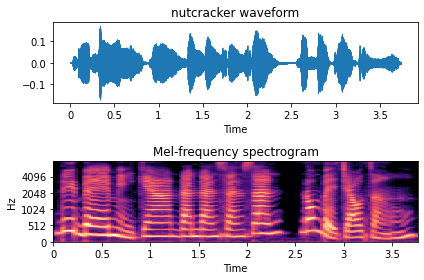

In [ ]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

# 繪波形圖
y, sr=librosa.load('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/train/1.wav')

librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set_title('nutcracker waveform')
print(sr)

# 繪梅爾頻譜
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
              y_axis='mel', sr=sr,
              fmax=8000, ax=ax[1])
ax[1].set_title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [7]:
mfcc_dim = 13

def load_and_trim(path):
  audio,sr = librosa.load(path) #可以讀取wav.mp3之類的檔家(返回值:音的信號值.採率)
  #audio = librosa.resample(audio, sr, 16000)
  energy = librosa.feature.rms(audio)#計算每幀的均方根(RMS)值
  frames = np.nonzero(energy >= np.max(energy) / 50)
  indices = librosa.core.frames_to_samples(frames)[1]
  audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
  return audio, sr


In [8]:
from tqdm import tqdm 
import librosa
import python_speech_features
from python_speech_features import mfcc
import random
features =[]
for i in tqdm(range(len(wav_files))):
  path = wav_files[i]
  audio, sr = load_and_trim(path)
  #print(sr)
  features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551, highfreq=8000))
# nfft = FFT大小,默認为512頻神點数(― 一般是2的女方)
#aud1o 告頻訊號
#sr : 探禄率
#nighfreg:最高带造(默認是SR的1/2
print(len(features), features[0].shape)

samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)
features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

100%|██████████| 3119/3119 [12:41<00:00,  4.10it/s]


3119 (940, 13)
[ -6.0386188   -5.02419101  -5.6094617    1.51584033 -15.04179257
  -5.4407739   -5.91428884 -11.76700347  -3.48609814 -12.65501049
  -7.23125538  -4.76239739   1.77279745]
[ 3.80748481 15.58124845 20.70663649 17.17759924 19.64611614 14.98679027
 14.91225484 15.9473795  13.97476656 14.92637146 12.51548464 13.01188357
 11.10983157]


In [9]:
chars = {}
for text in tran_texts:
  for e in text:
    chars[e] = chars.get(e, 0) + 1
    
chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100])

#作總號
char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}
print("char2id:",char2id)
print("id2char:",id2char)

27 [' ', 'i', 'a', 'n', 't', 'h', 's', 'u', 'o', 'k', 'g', 'e', 'l', 'p', 'b', 'm', 'j', 'r', 'c', 'd', 'f', 'y', 'v', 'w', 'x', 'q', 'z']
char2id: {' ': 0, 'i': 1, 'a': 2, 'n': 3, 't': 4, 'h': 5, 's': 6, 'u': 7, 'o': 8, 'k': 9, 'g': 10, 'e': 11, 'l': 12, 'p': 13, 'b': 14, 'm': 15, 'j': 16, 'r': 17, 'c': 18, 'd': 19, 'f': 20, 'y': 21, 'v': 22, 'w': 23, 'x': 24, 'q': 25, 'z': 26}
id2char: {0: ' ', 1: 'i', 2: 'a', 3: 'n', 4: 't', 5: 'h', 6: 's', 7: 'u', 8: 'o', 9: 'k', 10: 'g', 11: 'e', 12: 'l', 13: 'p', 14: 'b', 15: 'm', 16: 'j', 17: 'r', 18: 'c', 19: 'd', 20: 'f', 21: 'y', 22: 'v', 23: 'w', 24: 'x', 25: 'q', 26: 'z'}


In [74]:
data_index = np.arange(len(wav_files))
np.random.shuffle(data_index)
train_size = int(0.9 * len(wav_files))
test_size = len(wav_files) - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [tran_texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [tran_texts[i] for i in test_index]
print(len(X_test),len(X_train))

batch_size = 5
    
def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        
        yield (inputs, outputs)



312 2807


In [75]:
epochs = 6
num_blocks = 2
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[checkpointer, lr_decay])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/6
561/561 [==============================] - ETA: 0s - loss: 75.8892

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


561/561 [==============================] - 296s 487ms/step - loss: 75.8892 - val_loss: 118.9912 - lr: 0.0200
Epoch 2/6
561/561 [==============================] - 151s 268ms/step - loss: 38.6933 - val_loss: 50.1179 - lr: 0.0200
Epoch 3/6
561/561 [==============================] - 143s 256ms/step - loss: 33.7298 - val_loss: 42.1376 - lr: 0.0200
Epoch 4/6
561/561 [==============================] - 143s 254ms/step - loss: 28.6722 - val_loss: 36.9371 - lr: 0.0200
Epoch 5/6
561/561 [==============================] - 143s 254ms/step - loss: 25.6044 - val_loss: 32.8603 - lr: 0.0200
Epoch 6/6
561/561 [==============================] - 139s 248ms/step - loss: 23.9820 - val_loss: 40.7158 - lr: 0.0200


In [64]:
import pickle

sub_model.save('asr.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


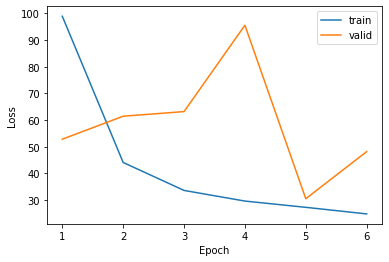

In [73]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [66]:
import os
set=4
os.chdir('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/test-shuf')
for filename in os.listdir():
  #print(filename)
  #print(filename.split(h.n)lol.zfill(set)ti.wavn)
  os.rename(filename,filename.split('.')[0].zfill(set)+'.wav')

In [70]:
from keras.models import load_model
folder_path ='/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/test-shuf/'
# Open one of the files,
wavs=[]
for data_file in sorted(os.listdir(folder_path)):
  wavs.append(data_file)
print('1:',wavs[0])
for i in range(len(wavs)):
  wavs[i]=os.path.join('/content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/test-shuf/',wavs[i])
print('2:',wavs[0])
with open('/content/dictionary.pkl', 'rb') as fr:
  [char2id,id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('/content/asr.h5')
print(len(wavs))
print('wavs=0',wavs[0])
j=0
z=1
result=[]
for i in range(len(wavs)):
  audio, sr = librosa.load(wavs[i])
  energy = librosa.feature.rms(audio)
  frames = np.nonzero(energy >= np.max(energy) / 5)
  indices = librosa.core.frames_to_samples(frames) [1]
  audio = audio[indices[0]: indices[-1]] if indices.size else audio[0:0]

  X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
  X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)

  pred = model.predict(np.expand_dims(X_data,axis=0))
  pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10,top_paths=1)[0][0])
  pred_ids = pred_ids.flatten().tolist()
  a=['']*(len(pred_ids))
  x=0
  for i in pred_ids:
    if(i!= -1):
      a[x]= id2char[i]
      print(id2char[i], end='')
      x = x+1
    else:
      break

  while '' in a:
    a.remove('')
  result.append(a)

  #audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
with open('speech_predict2.csv', 'w') as f:
  f.write('id,text\n')
  for i in range(len(wavs)):
    f.write(str(i+1)+ ','+''.join(result[i]) + '\n')
  f.close()

1: 0001.wav
2: /content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/test-shuf/0001.wav
346
wavs=0 /content/drive/MyDrive/Machine Learning/ML@NTUT-2021-Autumn-ASR/test-shuf/0001.wav
tso ho tsua sa ka riong pa kak tuika tsat kanoa ui fe ri e lingoing a uat tsia ka e lon loa m sian peasi siu jiap pe souma su kok u a pa so pi tai tshiang kaang e lapin kia bo ko lia u si lih ji tshiu phiu kuae si ko m ge kua lun ko ga ba ka hu tit king siok thaug kea la suan mo tau vre kui atiam tiunk tsiak ka kho khoa kisuasi s a e ho kien tik khui hia khbr la to si sasua guo tshi tshih tshun tsopuh la lai lai khang si tsia tkha sio tsiai hin tsik le i tua ln si bui tso si ts si tua kang tion ba si ashi sieae kuiatli tsit ie homben merl pu pura kohe tsu to pauh i kioe ke kheh i ke kak au tshitue ti k singbiia lu rae si sim lang kuau ben tsiok uet kanm ta sing khu ran kian lo siu tinmebe laouo kok ba si tsia pg si ebe ko khe a khu tsung te ua tshu bo la be iak khia o kok ba ika hitk tsoap pu tsit

In [ ]:
from keras.layers import Activation,BatchNormalization
Y_pred = Activation(BatchNormalization(convld(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=x, outputs=Y_pred)

def calc_ctc_loss(args):
  y, yp, ypl, yl = args
  return K.ctc_batch_cost(y, yp, ypl, yl)
  
ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_lengtn])